In [35]:
## Goal of this notebook is to generate N-dimensional lotka-volterra models 
using SparseArrays
using DifferentialEquations
using Plots
using DataFrames
using Polyhedra #For creating convex hulls
using QHull #For creating convex hulls

In [21]:
#Generate gamma and r matrix to pass to model - remains the same for a particular search
D= 4
X = rand(D, D)
  
r = rand(D, 1)
A = X
b = X[:, 1] .- r[1]
for i in 1:D-1
    A = blockdiag(sparse(A), sparse(X))
    b = vcat(b, X[:, i+1] .- r[i+1])
end
gammavec = A\b #Solve the linear system of equations
gamma_matrix = reshape(gammavec, D, D)' #Reshape as a DxD matrix and transpose

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0639206  0.0480176  -0.0511029  -0.188766
 -0.45326    1.02325    -0.0247446  -0.0914027
 -0.581205   0.0298138   0.968271   -0.117204
 -0.599513   0.0307529  -0.0327289   0.879104

In [22]:
function lotka_volterra(gamma_matrix, r, u0, endtime=100, resolution=200)
    function odes(du, u, p, t)
        gamma_matrix, r = p
        # du = u.*(r - u + gamma_matrix*u) #this is correct, .* stands for entry wise vector product
        for i in 1:size(gamma_matrix)[1]
            du[i] = u[i] * (r[i] - u[i] + sum(gamma_matrix[1, :].*u))
        end
    end

    tspan = [0, endtime] #Span of time to integrate for
    savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
    prob = ODEProblem(odes, u0, tspan, [gamma_matrix, r])
    sol = solve(prob, Tsit5(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    return sol
end

lotka_volterra (generic function with 4 methods)

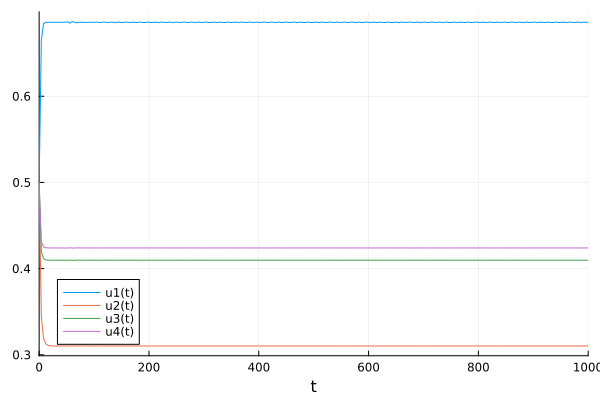

In [23]:
sol = lotka_volterra(gamma_matrix, r, [0.5, 0.5, 0.5, 0.5], 1E3, 250)
plot(sol)

In [75]:
#Sample parameter space
"""initial_sampling(lower_bounds, upper_bounds, n_init)
        Returns n_init samples between lower_bounds and upper_bounds. 
""" 
function initial_sampling(lower_bounds, upper_bounds, n_init)
    #Sample uniform points across space
    n_dims = length(lower_bounds)
    samples = Matrix{Float64}(undef, n_init, n_dims)
    for d in 1:n_dims
        lb = lower_bounds[d]
        ub = upper_bounds[d]
        for i in 1:n_init
            samples[i, d] = rand() * (ub - lb) + lb
        end
    end

    return samples
end

#Solve ODE and score
"""compute_classes(samples::Matrix(NxD))
        Given a set of initial conditions (samples), computes the steady state and converts to a string identifier for the class
"""
function compute_classes(samples, steady_states)
    classes = []
    for i in 1:size(samples, 1)
        ss = lotka_volterra(gamma_matrix, r, samples[i, :], 1E4, 250).u[end]
        found = false
        for s in steady_states
            if isapprox(ss, s, atol=0.01)
                push!(classes, class_name(s))
                found = true
                break
            end
        end
        if !found
            push!(steady_states, ss)
            push!(classes, class_name(ss))
        end
    end
    return classes, collect(steady_states)
end

function class_name(ss)
    return string(round(abs(ss[1]), digits=1))*", "*string(round(abs(ss[2]), digits=1))
end

function create_convex_hull(points)
    #Instantiates list of convex hulls based on a set of points 
    #Returns hull and convex hull metric
    hull = chull(mapreduce(permutedims, vcat, points))
    return hull, hull.volume
end

function generate_sample_data(samples, scores, classes, conv)
    D = size(samples, 2)
    # Preparing the column names and data for d1, d2, ..., dN
    column_names_and_data = [Symbol("d$i") => samples[:, i] for i in 1:D]

    # Creating additional columns
    additional_columns = [
        :score => scores, 
        :class => classes, 
        :conv => fill(conv, size(samples, 1))
    ]
    return DataFrame([column_names_and_data..., additional_columns...])
end

function generate_options_data(options, score_options, iter)
    D = size(options, 2)
    # Preparing the column names and data for d1, d2, ..., dN
    column_names_and_data = [Symbol("d$i") => options[:, i] for i in 1:D]

    # Creating additional columns
    additional_columns = [
        :pred_score => score_options, 
        :iter => fill(iter, size(options, 1))
    ]
    return DataFrame([column_names_and_data..., additional_columns...])
end

function create_convex_hull(points)
    #Instantiates list of convex hulls based on a set of points 
    #Returns hull and convex hull metric
    hull = chull(mapreduce(permutedims, vcat, points))
    return hull, hull.volume
end

function create_hulls_and_compute_volume(classes, samples)
    hulls = []
    total_volume = 0
    for c in unique(classes)
        class_indices = findall(x -> x == c, classes)
        hull_points = samples[class_indices, :]
        hull_points = [row[:] for row in eachrow(hull_points)]
        if length(class_indices) >= 4
            hull, vol = create_convex_hull(hull_points)
            total_volume = vol + total_volume
            push!(hulls, hull)
        end
    end
    return hulls, total_volume
end

function extract_hull_vertices(hulls)
    verts_total = []
    for j in 1:length(hulls)
        verts = [hulls[j].points[i, :] for i in hulls[j].vertices]
        push!(verts, verts[1, :][1])
        push!(verts_total, verts)
    end
    return verts_total
end

function computeGeometricCenter(verts)
    n = length(verts)
    if n == 0
        error("The list of vertices is empty.")
    end

    # Determine the dimensionality from the first vertex
    dim = length(verts[1])
    
    # Initialize a sum vector for all dimensions
    sumVec = zeros(Float64, dim)

    for vert in verts
        for d in 1:dim
            sumVec[d] += vert[d]
        end
    end

    # Compute the average for each coordinate
    centerVec = sumVec / n

    return centerVec
end

#Determine next sample balancing exploration/exploitation
function sampling(n_rand, lower_bounds, upper_bounds)
    D = length(lower_bounds)
    # Initialize an array to hold the random samples
    samples = zeros(n_rand, D)
    
    # For each dimension, scale and shift the random numbers
    for dim in 1:D
        # Generate uniform random numbers for this dimension
        rand_vals = rand(n_rand)
        
        # Scale and shift according to the bounds
        scale = upper_bounds[dim] - lower_bounds[dim]
        samples[:, dim] = lower_bounds[dim] .+ scale * rand_vals
    end
    return samples
end

function euclideanDistance(point1::Vector{Float64}, point2::Vector{Float64})::Float64
    return sqrt(sum((point1 - point2) .^ 2))
end

function acquisition_function(n_rand, hulls, lower_bounds, upper_bounds)
    #Compute hull vertices and volumes
    verts = extract_hull_vertices(hulls)
    old_vols = [hull.volume for hull in hulls]

    #Compute geometric centers of hulls from vertices
    centroids = []
    for i in 1:length(verts)
        push!(centroids, computeGeometricCenter(verts[i]))
    end

    #Compute and add to scores if outside hull
    scores = []
    options = []
    while length(scores) < n_rand
        sample_point = sampling(1,lower_bounds, upper_bounds)[1, :]
        score = 0
        inside_flag = 0
        for j in 1:length(centroids)
            score += euclideanDistance(centroids[j], sample_point)

            #Check if point is in convex hull
            hull_points = vcat(verts[j], [sample_point])
            new_hull, new_vol =  create_convex_hull(hull_points)
            if new_vol <= old_vols[j]
                inside_flag = 1
                break
            end
        end
        if inside_flag == 0
            push!(scores, score)
            push!(options, sample_point)
        end
    end
    return scores, hcat(options...)'
end


acquisition_function (generic function with 1 method)

In [88]:
function scan_steady_states(n_init=25, n_iters=100, n_rand=100, n_best=1, kernel=0)
    sample_data = DataFrame()
    options_data = DataFrame()
    steady_states = []

    #Define search space
    lower_bounds = [0., 0., 0., 0.]
    upper_bounds = [10., 10., 10., 10.]
    space_size = prod(upper_bounds .- lower_bounds)

    #Initial sampling
    samples = initial_sampling(lower_bounds, upper_bounds, n_init)

    #Solve ODE at initial samples
    classes, steady_states = compute_classes(samples, steady_states)
    scores = fill(0., length(classes))

    #Update sample data
    sample_data = vcat(sample_data, generate_sample_data(samples, scores, classes, "initial"))

    #Create current total hulls
    total_scores = []
    hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
    push!(total_scores, total_volume)

    #Bayesian loop
for i in 1:n_iters
    if total_scores[end]/space_size > 0.99
        print("Reached 90% coverage")
        break #Stop loop if reached 90% coverage
    end
    
        #Sample from posterior and select next sample
        score_options, init_values_options = acquisition_function(n_rand, hulls, lower_bounds, upper_bounds) #Sample and score n_rand possible options
        next_sample = init_values_options[argmax(score_options), :] #Select best possible options
    
        options_data = vcat(options_data, generate_options_data(init_values_options, score_options, i))
    
        # next_result = solve_ode(next_sample)
        next_class, steady_states = compute_classes(next_sample', steady_states)
    
        samples = vcat(samples, next_sample')
        classes = push!(classes, next_class[1])
    
        #Recompute hulls
        total_scores = []
        hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
        push!(total_scores, total_volume)
        push!(scores, total_volume)
    
        sample_data = vcat(sample_data, generate_sample_data(next_sample', total_scores[end], next_class[1], 100*total_scores[end]/space_size))
    end
    
    final_hulls, final_volume = create_hulls_and_compute_volume(classes, samples)
    final_verts = extract_hull_vertices(final_hulls)
    return steady_states, sample_data, final_hulls, final_verts, options_data
end

steady_states, sample_data, final_hulls, final_verts, options_data = scan_steady_states(10, 250, 25)

println("Total domains of attraction found: ", length(steady_states))
println("Locations of stable steady states: ", steady_states)

Total domains of attraction found: 1
Locations of stable steady states: Any[[0.6857365202484034, 0.3102833284093742, 0.40979996929251655, 0.4240405528326162]]
